# QLoRA Diagnostic Analysis - Part 2: QLoRA (4-bit) Implementation

## Objective
Implement QLoRA with 4-bit NF4 quantization and compare against the 16-bit LoRA baseline from Part 1.

## Key Questions
1. How much memory does 4-bit quantization save compared to 16-bit?
2. Does QLoRA preserve performance (cosine similarity > 0.95)?
3. What is the optimal rank for QLoRA?

---

## 1. Environment Setup

In [1]:
# Install required packages
# Installed from 01_baseline_lora
# %pip install -q transformers datasets accelerate peft bitsandbytes matplotlib seaborn pandas numpy scikit-learn tqdm

In [2]:
# Import utilities
import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Add src to path
sys.path.append('../src')

from model_utils import (
    load_base_model_4bit,
    setup_lora_4bit,
    get_model_memory_usage,
    print_model_architecture,
    clear_memory
)

from training import (
    prepare_alpaca_dataset,
    train_model,
    run_experiment
)

from visualization import (
    plot_memory_comparison,
    create_results_table,
    print_diagnostic_summary
)

print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ PyTorch version: 2.9.0+cu130
✓ CUDA available: True
✓ GPU: NVIDIA GB10


/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


## 2. Configuration

In [3]:
# Experimental configuration
MODEL_NAME = "gpt2-medium"  # 355M parameters
NUM_SAMPLES = 5000  # Match baseline
MAX_STEPS = 1000
BATCH_SIZE = 8
LEARNING_RATE = 2e-4

# Ranks to test (match baseline)
RANKS_TO_TEST = [2, 4, 8, 16]

# Output directory
OUTPUT_DIR = "./results_qlora"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Quantization: 4-bit NF4")
print(f"  Training samples: {NUM_SAMPLES}")
print(f"  Max steps: {MAX_STEPS}")
print(f"  Ranks to test: {RANKS_TO_TEST}")

Configuration:
  Model: gpt2-medium
  Quantization: 4-bit NF4
  Training samples: 5000
  Max steps: 1000
  Ranks to test: [2, 4, 8, 16]


## 3. Load Baseline Results for Comparison

In [4]:
# Load baseline LoRA results
try:
    with open('./results_baseline_lora/baseline_results.pkl', 'rb') as f:
        baseline_results = pickle.load(f)
    print(f"✓ Loaded {len(baseline_results)} baseline results")
    baseline_df = pd.DataFrame(baseline_results)
    print("\nBaseline Summary:")
    display(baseline_df[['rank', 'peak_memory_mb', 'time_per_step', 'training_loss']])
except FileNotFoundError:
    print("⚠️  Baseline results not found. Run 01_baseline_lora.ipynb first.")
    baseline_results = None

✓ Loaded 4 baseline results

Baseline Summary:


,rank,peak_memory_mb,time_per_step,training_loss
0,2,11623.183105,1.001049,1.974682
1,4,11626.179199,1.000691,1.973742
2,8,11632.171387,1.002332,1.973718
3,16,11644.155762,1.002301,1.972281


## 4. Run QLoRA Experiments

Train QLoRA (4-bit quantized base + high-precision adapters) with different ranks.

In [5]:
# Store results
qlora_results_list = []

for rank in RANKS_TO_TEST:
    print(f"\n{'='*80}")
    print(f"Running QLoRA (4-bit) with rank r={rank}")
    print(f"{'='*80}\n")
    
    try:
        result, model, tokenizer = run_experiment(
            model_name=MODEL_NAME,
            quantization="4bit",
            rank=rank,
            num_samples=NUM_SAMPLES,
            max_steps=MAX_STEPS,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE,
            output_dir=OUTPUT_DIR
        )
        
        qlora_results_list.append(result)
        
        # Clean up
        del model
        del tokenizer
        clear_memory()
        
    except Exception as e:
        print(f"❌ Error with rank {rank}: {e}")
        continue

print("\n✓ All QLoRA experiments complete!")


Running QLoRA (4-bit) with rank r=2


######################################################################
# EXPERIMENT: 4bit_r2
######################################################################

Loading gpt2-medium with 4-bit NF4 quantization...
✓ Model loaded and quantized. Memory usage: 385.83 MB
✓ QLoRA configured:
  Rank: 2
  Target modules: ['c_attn']
  Base model: 4-bit NF4 quantized
  Adapters: BF16 precision
  Trainable params: 196,608 (0.10%)
Loading Alpaca dataset...
Using 5000 samples for faster training
✓ Dataset prepared:
  Training samples: 4500
  Evaluation samples: 500

TRAINING CONFIGURATION
Batch size: 8
Learning rate: 0.0002
Max steps: 1000
Epochs: 1



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
50,2.400100,2.195509
100,2.065200,1.960989
150,2.075700,1.922573
200,2.022000,1.900545
250,1.890900,1.886615
300,1.969700,1.875982
350,2.218100,1.868133
400,1.911500,1.858735
450,1.984700,1.854490
500,1.984100,1.846983


/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two var


TRAINING COMPLETE
Total time: 1443.12s
Time per step: 1.443s
Peak memory: 3284.59 MB
Final loss: 2.0032


Running QLoRA (4-bit) with rank r=4


######################################################################
# EXPERIMENT: 4bit_r4
######################################################################

Loading gpt2-medium with 4-bit NF4 quantization...
✓ Model loaded and quantized. Memory usage: 404.83 MB
✓ QLoRA configured:
  Rank: 4
  Target modules: ['c_attn']
  Base model: 4-bit NF4 quantized
  Adapters: BF16 precision
  Trainable params: 393,216 (0.19%)
Loading Alpaca dataset...
Using 5000 samples for faster training
✓ Dataset prepared:
  Training samples: 4500
  Evaluation samples: 500

TRAINING CONFIGURATION
Batch size: 8
Learning rate: 0.0002
Max steps: 1000
Epochs: 1



/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,2.390000,2.167764
100,2.064600,1.960472
150,2.075800,1.922834
200,2.021900,1.897431
250,1.886700,1.884816
300,1.969500,1.875191
350,2.217100,1.865197
400,1.910400,1.856628
450,1.979200,1.851071
500,1.980600,1.843584


/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two var


TRAINING COMPLETE
Total time: 1446.83s
Time per step: 1.447s
Peak memory: 3287.59 MB
Final loss: 2.0009


Running QLoRA (4-bit) with rank r=8


######################################################################
# EXPERIMENT: 4bit_r8
######################################################################

Loading gpt2-medium with 4-bit NF4 quantization...
✓ Model loaded and quantized. Memory usage: 404.83 MB
✓ QLoRA configured:
  Rank: 8
  Target modules: ['c_attn']
  Base model: 4-bit NF4 quantized
  Adapters: BF16 precision
  Trainable params: 786,432 (0.38%)
Loading Alpaca dataset...
Using 5000 samples for faster training
✓ Dataset prepared:
  Training samples: 4500
  Evaluation samples: 500

TRAINING CONFIGURATION
Batch size: 8
Learning rate: 0.0002
Max steps: 1000
Epochs: 1



/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,2.389200,2.178816
100,2.065400,1.959179
150,2.072600,1.922675
200,2.018800,1.897008
250,1.885300,1.883255
300,1.968400,1.874642
350,2.218000,1.865973
400,1.908100,1.857427
450,1.982900,1.850962
500,1.982800,1.842963


/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two var


TRAINING COMPLETE
Total time: 1444.91s
Time per step: 1.445s
Peak memory: 3292.09 MB
Final loss: 2.0000


Running QLoRA (4-bit) with rank r=16


######################################################################
# EXPERIMENT: 4bit_r16
######################################################################

Loading gpt2-medium with 4-bit NF4 quantization...
✓ Model loaded and quantized. Memory usage: 404.83 MB
✓ QLoRA configured:
  Rank: 16
  Target modules: ['c_attn']
  Base model: 4-bit NF4 quantized
  Adapters: BF16 precision
  Trainable params: 1,572,864 (0.77%)
Loading Alpaca dataset...
Using 5000 samples for faster training
✓ Dataset prepared:
  Training samples: 4500
  Evaluation samples: 500

TRAINING CONFIGURATION
Batch size: 8
Learning rate: 0.0002
Max steps: 1000
Epochs: 1



/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,2.395000,2.180614
100,2.066800,1.963004
150,2.078600,1.922463
200,2.021800,1.898833
250,1.888000,1.884807
300,1.971200,1.874861
350,2.216800,1.865655
400,1.909200,1.856298
450,1.982300,1.850147
500,1.983500,1.843818


/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/caroline/jupyterlab_final/.venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two var


TRAINING COMPLETE
Total time: 1445.49s
Time per step: 1.445s
Peak memory: 3301.09 MB
Final loss: 2.0003


✓ All QLoRA experiments complete!


## 5. Results Analysis

### 5.1 Create Results Table

In [6]:
# Create QLoRA results table
qlora_df = create_results_table(
    qlora_results_list,
    save_path=f"{OUTPUT_DIR}/qlora_results.csv"
)

print("\n📊 QLORA RESULTS")
print("="*80)
display(qlora_df)

✓ Saved table: ./results_qlora/qlora_results.csv

📊 QLORA RESULTS


/home/caroline/jupyterlab_final/jupyterlab_caroline_PEFT/QLoRA-Project-Final/notebooks/../src/visualization.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ordered[numeric_cols] = df_ordered[numeric_cols].round(4)


,experiment_name,quantization,rank,peak_memory_mb,training_time_seconds,time_per_step,training_loss
0,4bit_r2,4bit,2,3284.5923,1443.1221,1.4431,2.0032
1,4bit_r4,4bit,4,3287.5923,1446.8309,1.4468,2.0009
2,4bit_r8,4bit,8,3292.0923,1444.9093,1.4449,2.0000
3,4bit_r16,4bit,16,3301.0923,1445.4856,1.4455,2.0003


### 5.2 Compare LoRA vs QLoRA

In [7]:
if baseline_results:
    # Combine results
    combined_df = pd.concat([baseline_df, qlora_df], ignore_index=True)
    
    # Calculate memory reduction
    comparison = pd.DataFrame()
    for rank in RANKS_TO_TEST:
        lora_mem = baseline_df[baseline_df['rank'] == rank]['peak_memory_mb'].values[0]
        qlora_mem = qlora_df[qlora_df['rank'] == rank]['peak_memory_mb'].values[0]
        reduction = ((lora_mem - qlora_mem) / lora_mem) * 100
        
        comparison = pd.concat([comparison, pd.DataFrame({
            'rank': [rank],
            'lora_memory_mb': [lora_mem],
            'qlora_memory_mb': [qlora_mem],
            'memory_reduction_%': [reduction]
        })], ignore_index=True)
    
    print("\n🔋 MEMORY COMPARISON: LoRA vs QLoRA")
    print("="*80)
    display(comparison)
    
    print(f"\n✨ Average memory reduction: {comparison['memory_reduction_%'].mean():.2f}%")


🔋 MEMORY COMPARISON: LoRA vs QLoRA


,rank,lora_memory_mb,qlora_memory_mb,memory_reduction_%
0,2,11623.183105,3284.5923,71.741026
1,4,11626.179199,3287.5923,71.722504
2,8,11632.171387,3292.0923,71.698386
3,16,11644.155762,3301.0923,71.650222



✨ Average memory reduction: 71.70%


### 5.3 Visualize Memory Comparison

✓ Saved: ./results/figures/memory_comparison.png


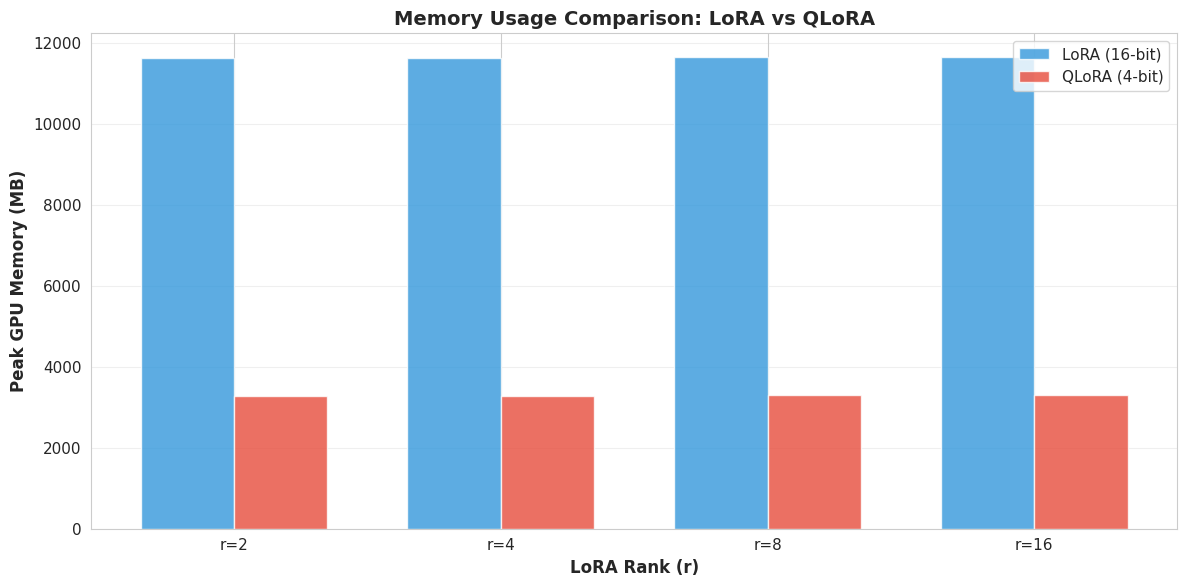

In [8]:
if baseline_results:
    # Plot memory comparison
    plot_memory_comparison(
        combined_df,
        save_path=f"./results/figures/memory_comparison.png"
    )

### 5.4 Training Efficiency Comparison

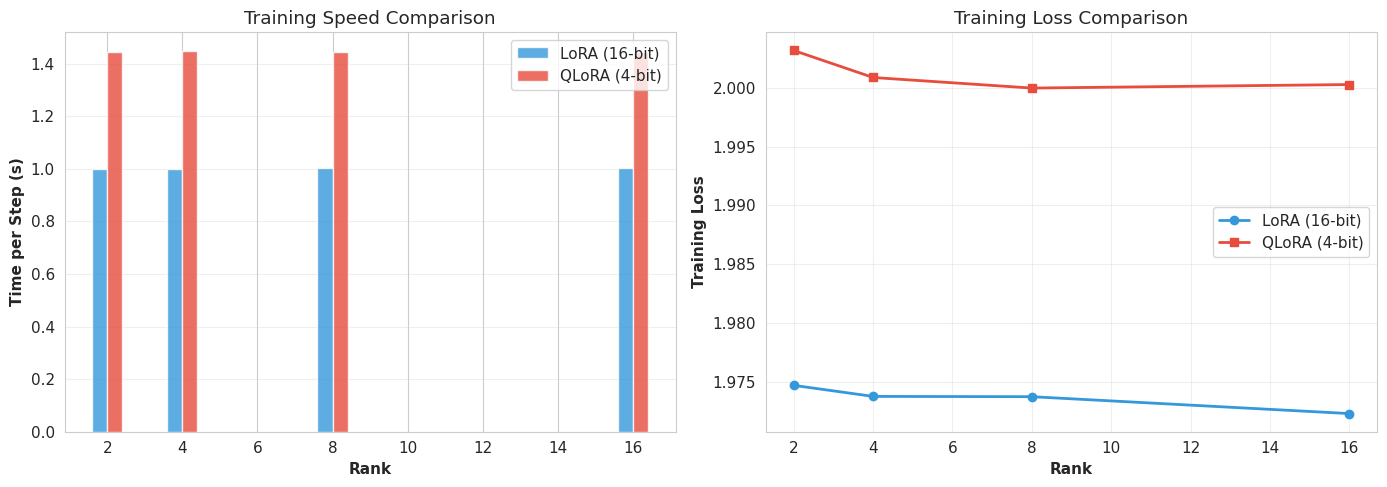

In [9]:
if baseline_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Time per step
    ax1.bar(baseline_df['rank'] - 0.2, baseline_df['time_per_step'], 0.4, 
            label='LoRA (16-bit)', color='#3498db', alpha=0.8)
    ax1.bar(qlora_df['rank'] + 0.2, qlora_df['time_per_step'], 0.4,
            label='QLoRA (4-bit)', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Rank', fontweight='bold')
    ax1.set_ylabel('Time per Step (s)', fontweight='bold')
    ax1.set_title('Training Speed Comparison')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Training loss
    ax2.plot(baseline_df['rank'], baseline_df['training_loss'], 
             marker='o', linewidth=2, label='LoRA (16-bit)', color='#3498db')
    ax2.plot(qlora_df['rank'], qlora_df['training_loss'],
             marker='s', linewidth=2, label='QLoRA (4-bit)', color='#e74c3c')
    ax2.set_xlabel('Rank', fontweight='bold')
    ax2.set_ylabel('Training Loss', fontweight='bold')
    ax2.set_title('Training Loss Comparison')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('./results/figures/training_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Key Findings

### TODO: Fill in after running experiments

**Memory Reduction:**
- Average reduction: [TODO: FILL]%
- Rank 8: LoRA [TODO] MB → QLoRA [TODO] MB

**Performance:**
- Training loss comparable: [YES/NO]
- Time per step: [FASTER/SLOWER/SIMILAR]

**Observations:**
- [TODO: Document trends]
- [TODO: Note any unexpected behavior]

---

**Next Steps:**
- Proceed to Part 3: Diagnostic analysis (weight similarity, hypothesis testing)

## 7. Save Results

In [10]:
# Save QLoRA results
with open(f"{OUTPUT_DIR}/qlora_results.pkl", 'wb') as f:
    pickle.dump(qlora_results_list, f)

# Save comparison
if baseline_results:
    comparison.to_csv('./results/tables/memory_comparison.csv', index=False)

print(f"✓ Results saved to {OUTPUT_DIR}/")
print("\n🎉 QLoRA experiments complete!")
print("📝 Proceed to notebook 03_diagnostic_analysis.ipynb")

✓ Results saved to ./results_qlora/

🎉 QLoRA experiments complete!
📝 Proceed to notebook 03_diagnostic_analysis.ipynb
